# Identify transects

## Overview
This notebook contains two ways transects (i.e., boundaries of a chosen region) can be identified. 
<ol>
    <li> Given desired locations of points through which we want a transect to cross through, identify the consecutive edges and vertices between them. Then create a mask (i.e., find all the points that are enclosed by the transect). </li>
    <li> Given a mask, identify consecutive edges and vertices that are on the border of this mask.</li>
</ol>

In [1]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools
from mpas_tools.planar_hex import make_planar_hex_mesh
from mpas_tools.mesh.conversion import convert, cull, mask
from mpas_tools.io import write_netcdf
from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from geometric_features import read_feature_collection
from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import mpasregions.sections as mps

### Set up datasets
**To create a base mask (a global "mask" filled with 1s):**
```ruby
# create a global base mask of ones everywhere. 
# We will then apply the mask where we specifically choose nCells, nVertices, and nEdges that are contained in the original mask to this basemask 
# This creates a new mask with all parts of the cell included. 


# create a base mask
mask['regionCellMasks'] = mask.regionCellMasks * 0 + 1
mask['regionVertexMasks'] = mask.regionVertexMasks * 0 + 1
mask['regionEdgeMasks'] = mask.regionEdgeMasks * 0 + 1
mask['regionNames'] = 'whole cell LS'
mask.attrs['How to use'] = 'open separate dataset with nCell, nVertices, nEdges xr index arrays. base_mask.regionCellMasks.where(base_mask.nCells.isin(cells_inside),other = 0)'
mask.to_netcdf('/global/homes/k/kuyeda/WMT_NBs/mpas-o_EC30to60_global_base_mask.nc',format='netCDF4',mode='w')
mask
```

**To convert the original mask .geojson file to a .nc file:**
```ruby
# convert geojson to .nc mask file

wmtnb_filepath = '/global/u2/k/kuyeda/WMT_NBs/'
fcMask = read_feature_collection(wmtnb_filepath + 'LS_test.geojson')
# pool = create_pool(process_count=8)
dsMasks = compute_mpas_region_masks(
    dsMesh, fcMask, maskTypes=('cell', 'vertex', 'edge'), pool=pool
)
# dsMasks.to_netcdf(wmtnb_filepath + 'LS_CEV_masks.nc', format='NETCDF4', mode='w')
```

**To switch between ID and indices** 

Code to convert between ID (called `n`) and index (called `xr`) is shown below. 
`__On__` will give `n` coordinates (IDs). \ 
`nCells/Edges/Vertices` will give `xr` coordinates (indices).

Also, just subtracting one feels easier and there is a straightforward conversion from ID (n) to index (xr) values. But the equivalent functions are below
```ruby
def xr_to_n_idx(xr):
    return xr+1
```

The equivalent conversion from  the index (xr) to ID (n) is
```ruby
cell_part = 'Cell' # 'Edge', 'Vertex'
ds = mesh
def idx_to_id(idx,cell_part,ds):
    id = ds[f'indexTo{cell_part}ID'].isel(nCells=idx).values
    return id
```

### Open necessary datasets
```mesh``` $\rightarrow$ contains information about the mesh and cells \
```dso``` $\rightarrow$ diagnostics from the simulations (datavariables we actually want to plot) \
```mask``` $\rightarrow$ a mask of 0s and 1s created from a geojson file (created using geojson.io) that was then converted into a netcdf file using ```compute_mpas_region_masks``` \
```base_mask``` $\rightarrow$ a mask of 1s for the entire globe.


In [31]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open original (from geojson file) mask to use to make dataset smaller
wmtnb_filepath = './'
mask = xr.open_dataset(wmtnb_filepath + 'LS_CEV_masks.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')

/tmp/ipykernel_1621544/3657922681.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


## Part 1: Algorithm to create transects
### Identify transect based on desired transect location

In [11]:
LS_lats= np.array([54, 60, 66, 64, 58])   
LS_lons= np.array([302, 315, 310, 295, 296])

LS_lats = np.append(LS_lats, LS_lats[0])
LS_lons = np.append(LS_lons, LS_lons[0])

test_verts, test_edges = mps.calculate_transects_multiple_pts(LS_lons, LS_lats, mesh, mask)

In [32]:
# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

Text(0.5, 0.98, 'Transect from Algorithm')

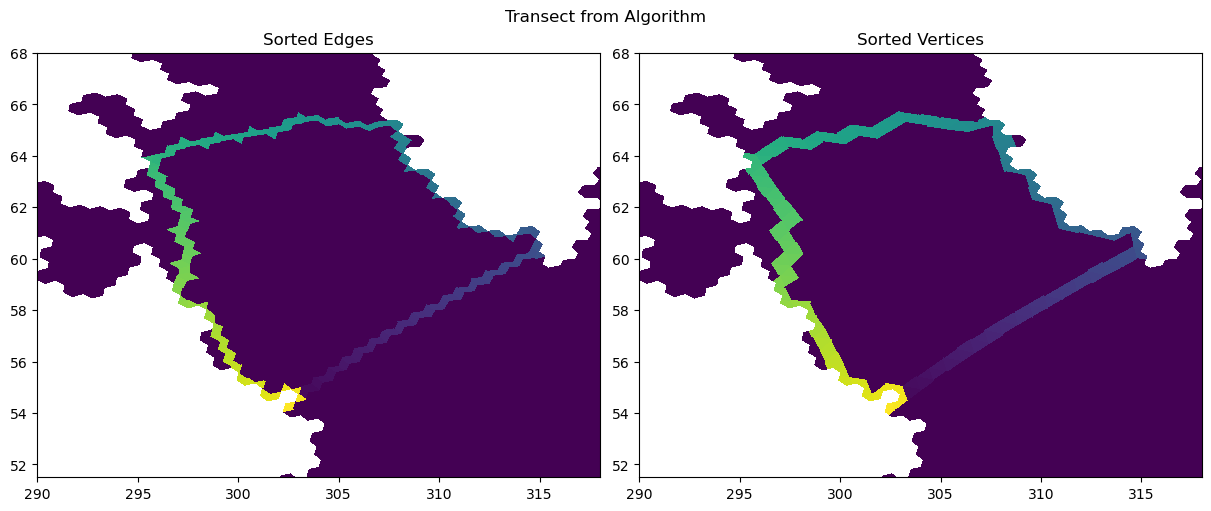

In [36]:
# assign index numbers to each of the chosen region masks to check sorted order 
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(test_edges),other=0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(test_verts),other=0)

# assign index value to sorted edges and vertices 

modified_test_edges = test_edges[test_edges != -1]
for i in range(0,len(modified_test_edges)):
    base_mask.regionEdgeMasks.isel(nRegions=0)[np.int32(modified_test_edges[i])]= i

for i in range(0,len(test_verts)):
    base_mask.regionVertexMasks.isel(nRegions=0)[np.int32(test_verts[i])]= i

fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
c = mosaic.polypcolor(ax[0],descriptor,
                  base_mask.regionEdgeMasks.isel(nRegions=0),cmap='viridis',
                  antialiaseds=False)

d = mosaic.polypcolor(ax[1],descriptor,
                  base_mask.regionVertexMasks.isel(nRegions=0),cmap='viridis',
                  antialiaseds=False)

ax[0].set_title('Sorted Edges')
ax[1].set_title('Sorted Vertices')

# LS
for i in range(0,2):
    ax[i].set_xlim(290, 318)
    ax[i].set_ylim(51.5, 68)

fig.suptitle('Transect from Algorithm')

## Create a geojson file using the vertex lats and lons we just found. Then create a mask for all the points contained by this transect.

In [14]:
# get the lats and lons of the test_verts 
test_verts_lats = mesh.latVertex.isel(nVertices = np.int32(test_verts)) * 180 / np.pi 
test_verts_lons = mesh.lonVertex.isel(nVertices = np.int32(test_verts)) * 180 / np.pi - 360

In [15]:
test_verts_lonslats = np.array([test_verts_lons,test_verts_lats]).T
list_test_verts_lonslats = test_verts_lonslats.tolist()

(156, 2)

In [17]:
transect_from_alg = {
    "type": "FeatureCollection",
    "features": [{
        "type": "Feature",
        "properties":{
            "name":"Labrador Sea from transect algorithm",
            "tags":"Labrador_Sea;Davis_Strait",
            "object":"region",
            "component":"ocean",
            "author":"Kaila Uyeda"
        },
        "geometry": {
            "coordinates":[list_test_verts_lonslats],
            "type": "Polygon"
        }
    }]
}


wmtnb_filepath = './'
# save to a geojson file
# with = open and then close
# w = write mode

with open(wmtnb_filepath+'LS_test_transect_from_alg.geojson','w') as f:
    geojson.dump(transect_from_alg, f, indent=2)

print('file saved')

file saved


In [18]:
# DO NOT DELETE THIS CELL (YOU JUSET ONLY NEED TO RUN IT ONCE)
# # convert geojson to .nc mask file

# wmtnb_filepath = './'
# fcMask = read_feature_collection(wmtnb_filepath + 'LS_test_transect_from_alg.geojson')
# pool = create_pool(process_count=8)
# dsMasks = compute_mpas_region_masks(
#     mesh, fcMask, maskTypes=('cell','edge','vertex'), pool=pool
# )

In [19]:
# dsMasks.to_netcdf(wmtnb_filepath + 'LS_test_transect_from_alg.nc', format='NETCDF4', mode='w')
dsMasks = xr.open_dataset(wmtnb_filepath + 'LS_test_transect_from_alg.nc')

In [20]:
cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
edgemask = dsMasks.regionEdgeMasks.isel(nRegions=0).astype(bool)
vertexmask = dsMasks.regionVertexMasks.isel(nRegions=0).astype(bool)

Text(0.5, 0.98, 'Grid variables from mask made from transect algorithm + MPAS-Tools')

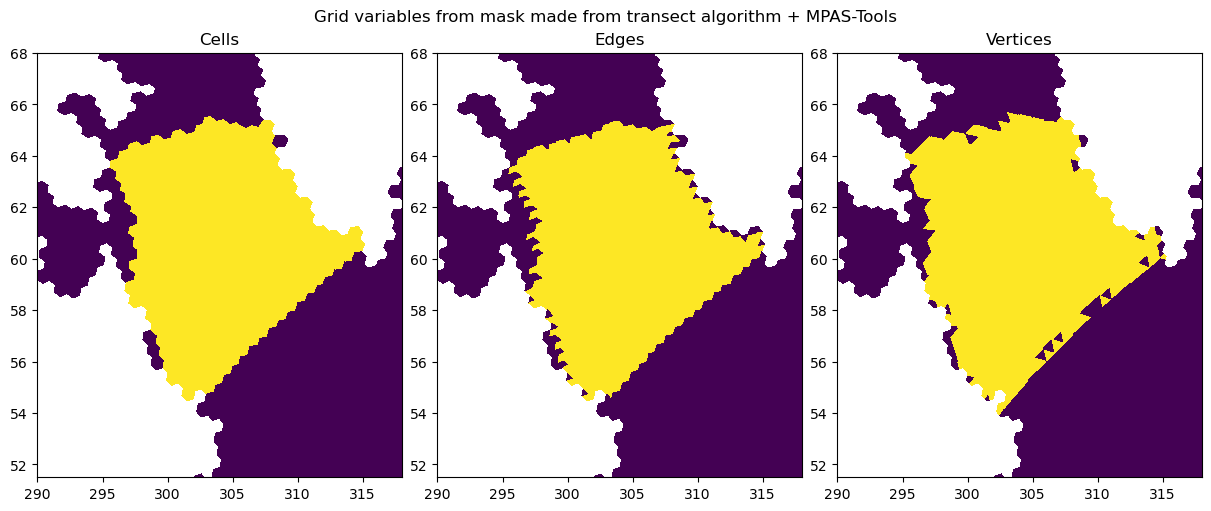

In [37]:
# plot this masked region
fig,ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True,figsize=(12,5))

new_cmap = plt.get_cmap('viridis')
new_cmap.set_under('magenta')

c = mosaic.polypcolor(ax[0],descriptor,
                  cellmask.astype(int),cmap='viridis',
                  antialiaseds=False)
d = mosaic.polypcolor(ax[1],descriptor,
                  edgemask.astype(int),cmap='viridis',
                  antialiaseds=False)
e = mosaic.polypcolor(ax[2],descriptor,
                  vertexmask.astype(int),cmap='viridis',
                  antialiaseds=False)

# fig.colorbar(c, extend='both')

# LS
for i in range(0,3):
    ax[i].set_xlim(290, 318)
    ax[i].set_ylim(51.5, 68)

ax[0].set_title('Cells')
ax[1].set_title('Edges')
ax[2].set_title('Vertices')
fig.suptitle('Grid variables from mask made from transect algorithm + MPAS-Tools')

the mismatch between the length of the `test_verts_lons` (creating geojson file from alg transect) and the `vertex_lons` (vertices in the .nc file made from the geojson file) makes me feel like something is wrong... To which grid coordinate do the geojson lats and lons get assigned? They are using the same points (`len(np.intersect1d(test_verts_lons + 360, vertex_lons))` is equal to the length of `vertex_lons`, but I don't understand why there are `len(test_verts_lons)-len(vertex_lons)` = 15 missing points. 

In [22]:
alg_edges, alg_vertices = mps.xr_sorted_transect_edges_and_vertices(mesh,dsMasks)

In [23]:
len(test_verts_lons)

156

In [24]:
len(alg_vertices)

142

Text(0.5, 0.98, 'Sorted vertex & edge locations')

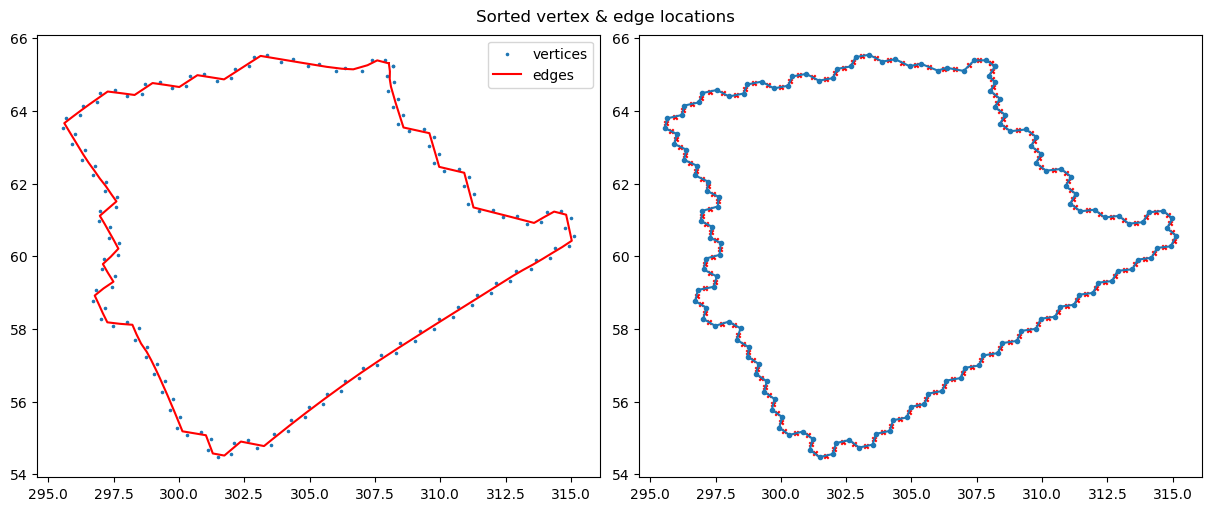

In [38]:
# plot using vertex lats and lons
vertex_lons = mesh.lonVertex.isel(nVertices = alg_vertices) * 180 / np.pi
vertex_lats = mesh.latVertex.isel(nVertices = alg_vertices) * 180 / np.pi

# plot using edge lats and lons
edge_lons = mesh.lonEdge.isel(nEdges = alg_edges) * 180 / np.pi
edge_lats = mesh.latEdge.isel(nEdges = alg_edges) * 180 / np.pi

fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
v = ax[0].scatter(vertex_lons, vertex_lats,marker='.',label='vertices')
v.set_sizes([10])
ax[0].plot(edge_lons,edge_lats,color='red',label='edges')

ax[1].plot(vertex_lons, vertex_lats, marker='.')
s = ax[1].scatter(edge_lons,edge_lats,color='red',marker='x')
s.set_sizes([10])
ax[0].legend()

fig.suptitle('Sorted vertex & edge locations')

<div class="alert alert-warning" role="alert">
  <b>END OF TRANSECT CREATION FROM ALGORITHM </b> 
</div>


# Part 2: Mask to create transects

In [26]:
next_edges, next_vertices = mps.xr_sorted_transect_edges_and_vertices(mesh,mask)

Text(0.5, 0.98, 'Transect from Mask')

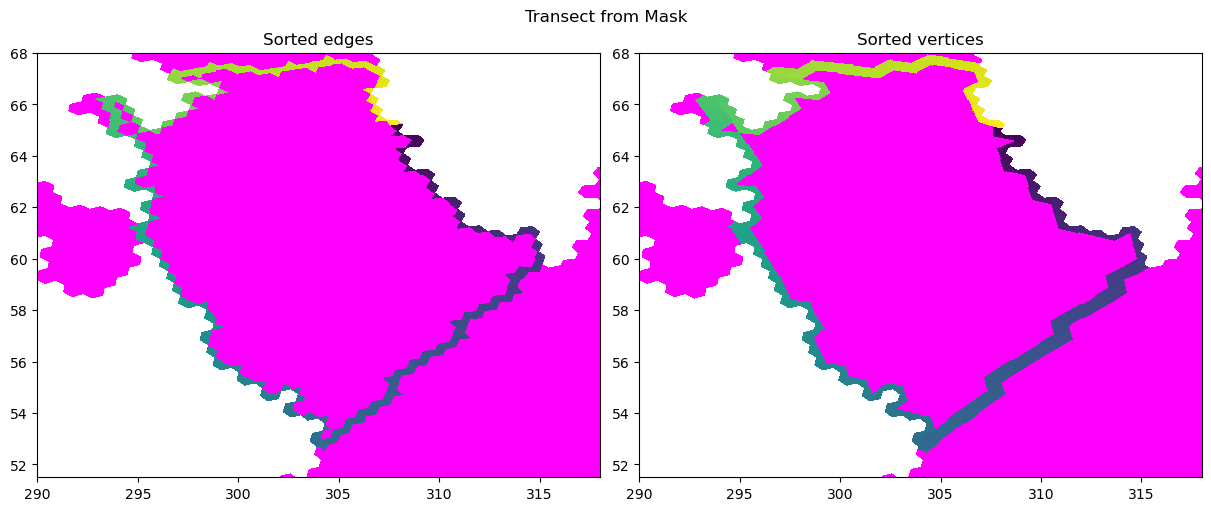

In [46]:
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# LS
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(next_edges),other=0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(next_vertices),other=0)

for i in range(0,len(next_edges)):
    base_mask.regionEdgeMasks.isel(nRegions=0)[np.int32(next_edges[i])]= i+1

for i in range(0,len(next_edges)):
    base_mask.regionVertexMasks.isel(nRegions=0)[np.int32(next_vertices[i])]= i+1


fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))

new_cmap = plt.get_cmap('viridis')
new_cmap.set_under('magenta')

c = mosaic.polypcolor(ax[0],descriptor,
                  base_mask.regionEdgeMasks.isel(nRegions=0),cmap=new_cmap,vmin=1,
                  antialiaseds=False)

d = mosaic.polypcolor(ax[1],descriptor,
                  base_mask.regionVertexMasks.isel(nRegions=0),cmap=new_cmap,vmin=1,
                  antialiaseds=False)


# LS
for i in range(0,2):
    ax[i].set_xlim(290, 318)
    ax[i].set_ylim(51.5, 68)

ax[0].set_title('Sorted edges')
ax[1].set_title('Sorted vertices')

fig.suptitle('Transect from Mask')

Text(0.5, 0.98, 'Sorted vertex & edge locations')

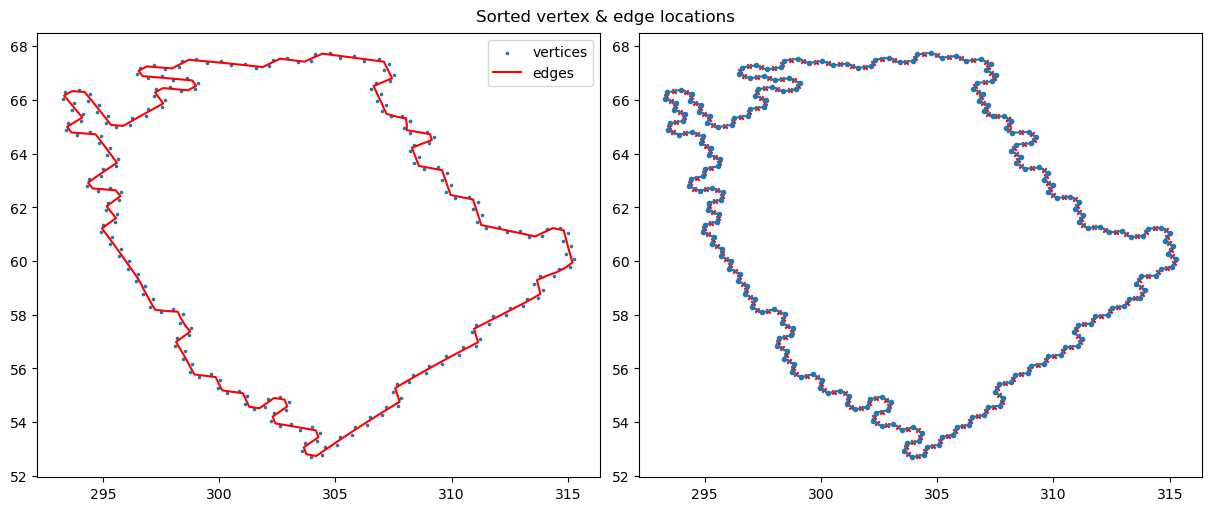

In [47]:
# plot using vertex lats and lons
vertex_lons = mesh.lonVertex.isel(nVertices = next_vertices) * 180 / np.pi
vertex_lats = mesh.latVertex.isel(nVertices = next_vertices) * 180 / np.pi

# plot using edge lats and lons
edge_lons = mesh.lonEdge.isel(nEdges = np.int32(next_edges)) * 180 / np.pi
edge_lats = mesh.latEdge.isel(nEdges = np.int32(next_edges)) * 180 / np.pi

fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
v = ax[0].scatter(vertex_lons, vertex_lats,marker='.',label='vertices')
v.set_sizes([10])
ax[0].plot(edge_lons,edge_lats,color='red',label='edges')

ax[1].plot(vertex_lons, vertex_lats, marker='.')
s = ax[1].scatter(edge_lons,edge_lats,color='red',marker='x')
s.set_sizes([10])
ax[0].legend()

fig.suptitle('Sorted vertex & edge locations')